In [1]:
ASSET = "DOGEUSDT"
TARGET = "Close"
SAVE_DF = f"./-for_optimization-/{ASSET}_{TARGET}_df.csv"
SAVE_SCALER = f"./-for_optimization-/{ASSET}_{TARGET}_scaler.pkl"
SAVE_MODEL = f"./-for_optimization-/{ASSET}_{TARGET}_model.keras"
SAVE_PREDICTIONS = f"./-for_optimization-/{ASSET}_{TARGET}_predictions.csv"


import optuna
from keras.optimizers import Adam, RMSprop
from keras.models import Sequential
from keras.layers import LSTM, Dense
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, LSTM, Dense
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping

import importlib
# from __imports__ import *
import data, LSTM_returns
importlib.reload(data)


c:\Users\IC2594\AppData\Local\miniconda3\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


<module 'data' from 'c:\\Users\\IC2594\\crypto\\folder-1\\data\\__init__.py'>

In [2]:
import numpy as np
import pandas as pd
import ta  # pip install ta

def compute_slope(series):
    y = series.values
    x = np.arange(len(y))
    if len(y) == 0:
        return np.nan
    return np.polyfit(x, y, 1)[0]

def add_technical_features(df, look_back=14):
    df = df.copy()  # avoid modifying original

    # Return: Daily log return
    df['Return'] = np.log(df['Close'] / df['Close'].shift(1))

    # Risk: Rolling std dev (volatility)
    df['Risk'] = df['Return'].rolling(window=look_back).std()

    # RSI
    df['RSI'] = ta.momentum.RSIIndicator(close=df['Close'], window=look_back).rsi()

    # ADX
    df['ADX'] = ta.trend.ADXIndicator(high=df['High'], low=df['Low'], close=df['Close'], window=look_back).adx()

    # Momentum
    df['MOM'] = df['Close'] - df['Close'].shift(look_back)

    # High-low spread
    df['HL'] = df['High'] - df['Low']

    # High-open & low-open
    df['HO'] = df['High'] - df['Open']
    df['LO'] = df['Low'] - df['Open']

    # Buy pressure ratio
    df['buy_pressure_ratio'] = df['Taker buy quote asset volume'] / df['Quote asset volume']

    # Trades per volume
    df['trades_per_volume'] = df['Number of trades'] / df['Quote asset volume']

    # Rolling slope
    df['slope'] = df['Close'].rolling(window=look_back).apply(compute_slope, raw=False)

    df['MA_7'] = df['Close'].rolling(window=7).mean()

    df['MA_14'] = df['Close'].rolling(window=14).mean()


    # Drop NaN from lookback window
    df = df.dropna()

    # Drop unnecessary columns
    cols_to_drop = [
        'Open', 'High', 'Low', 'Quote asset volume',
        'Number of trades', 'Taker buy base asset volume',
        'Taker buy quote asset volume', 'F&G'
    ]
    df = df.drop(columns=[col for col in cols_to_drop if col in df.columns])

    return df

df = data.load_asset(ASSET, sampling='1d')
df = data.add_fear_and_greed(df)
# Restrict data after 2022
df = add_technical_features(df)
df = df[df.index >= '2022-01-01']
df = df[df.index <= '2025-01-01']
split = len(df[df.index >= '2024-06-01']) / len(df)
df.head()

,Close,Volume,F&G category,Return,Risk,RSI,ADX,MOM,HL,HO,LO,buy_pressure_ratio,trades_per_volume,slope,MA_7,MA_14
Open time,,,,,,,,,,,,,,,,
2022-01-01,0.1732,2.975041e+08,Extreme Fear,0.016885,0.033048,44.190785,20.670453,0.0009,0.0040,0.0034,-0.0006,0.532811,0.001528,0.000004,0.176314,0.176886
2022-01-02,0.1745,3.129559e+08,Fear,0.007478,0.032705,45.171335,20.229684,0.0051,0.0058,0.0032,-0.0026,0.521954,0.001912,-0.000311,0.174129,0.177250
2022-01-03,0.1703,4.609854e+08,Fear,-0.024363,0.033223,42.569086,20.080075,0.0032,0.0071,0.0000,-0.0071,0.513585,0.001768,-0.000844,0.171614,0.177479
2022-01-04,0.1684,4.964392e+08,Extreme Fear,-0.011219,0.032855,41.406973,20.017871,-0.0023,0.0061,0.0023,-0.0038,0.520611,0.001510,-0.001327,0.170829,0.177314
2022-01-05,0.1590,1.084632e+09,Extreme Fear,-0.057438,0.035796,36.149096,21.302001,-0.0140,0.0238,0.0025,-0.0213,0.480378,0.001754,-0.001993,0.169543,0.176314


In [3]:
# Hyperparameters (from Optuna)
UNITS_L0 = 160
DROPOUT_L0 = 0.0
LEARNING_RATE = 0.000728
BATCH_SIZE = 32
MAX_EPOCHS = 50

def train_lstm(df, sequence_length=30, test_size=split, target='MA_7'):
    # Prepare data
    features = [
        'Close', 'Volume', 'F&G category', 'Return', 'Risk', 'RSI', 'ADX',
        'MOM', 'HL', 'HO', 'LO', 'buy_pressure_ratio', 'trades_per_volume', 
        'slope', 'MA_7', 'MA_14'
    ]
    num_feats = [f for f in features if f != 'F&G category']
    df_num = df[num_feats]
    df_cat = pd.get_dummies(df['F&G category'], prefix='F_G')
    df_all = pd.concat([df_num, df_cat], axis=1).dropna()
    target_idx = list(df_all.columns).index(target)
    # Move the target column to the last position
    columns = list(df_all.columns)
    columns.append(columns.pop(target_idx))
    df_all = df_all[columns]
    target_idx = len(columns) - 1

    scaler = MinMaxScaler()
    data_scaled = scaler.fit_transform(df_all)

    # Build sequences
    X, y = zip(*[
        (data_scaled[i-sequence_length:i], data_scaled[i, target_idx])
        for i in range(sequence_length, len(data_scaled))
    ])
    X, y = np.array(X), np.array(y)

    # Train-test split
    X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=test_size, shuffle=False)

    # Build and compile model
    model = Sequential([
        Input(shape=(sequence_length, X.shape[2])),
        LSTM(UNITS_L0, dropout=DROPOUT_L0),
        Dense(1, activation='linear')
    ])
    model.compile(optimizer=Adam(learning_rate=LEARNING_RATE), loss='mean_squared_error')

    # Train model
    es = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
    history = model.fit(X_train, y_train, validation_data=(X_val, y_val), 
                        epochs=MAX_EPOCHS, batch_size=BATCH_SIZE, callbacks=[es], verbose=1)

    return model, scaler, history, (X_val, y_val), df_all, data_scaled



In [4]:
def objective(trial):
    global UNITS_L0, DROPOUT_L0, LEARNING_RATE, BATCH_SIZE, MAX_EPOCHS

    # Suggest hyperparameters
    UNITS_L0 = trial.suggest_int("units_l0", 50, 200)
    DROPOUT_L0 = trial.suggest_float("dropout_l0", 0.0, 0.5)
    LEARNING_RATE = trial.suggest_loguniform("learning_rate", 1e-5, 1e-2)
    BATCH_SIZE = trial.suggest_categorical("batch_size", [16, 32, 64])
    MAX_EPOCHS = trial.suggest_int("max_epochs", 10, 100)
    sequence_length = trial.suggest_int("sequence_length", 10, 60)


    # Train the LSTM model
    model, scaler, history, (X_val, y_val), _, _ = train_lstm(
        df,
        sequence_length=sequence_length,
        test_size=split,
        target=TARGET
    )

    # Predict on validation set
    y_pred = model.predict(X_val).flatten()

    # Create a placeholder array with zeros, except for the last column (target)
    dummy = np.zeros((len(y_pred), X_val.shape[2]))
    dummy[:, -1] = y_pred

    # Inverse transform using the entire dummy array
    y_pred_inv = scaler.inverse_transform(dummy)[:, -1]

    # Inverse transform for the actual values
    dummy_y_val = np.zeros((len(y_val), X_val.shape[2]))
    dummy_y_val[:, -1] = y_val
    y_val_inv = scaler.inverse_transform(dummy_y_val)[:, -1]

    # Calculate MSE
    mse = mean_squared_error(y_val_inv, y_pred_inv)

    return mse

# Run Optuna optimization
study = optuna.create_study(direction="minimize")
study.optimize(objective, n_trials=40)

[I 2025-05-09 19:33:39,392] A new study created in memory with name: no-name-80250c11-bf4c-43e4-9fcc-8e7810b4f486


Epoch 1/53


C:\Users\IC2594\AppData\Local\Temp\ipykernel_1272\157944328.py:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  LEARNING_RATE = trial.suggest_loguniform("learning_rate", 1e-5, 1e-2)


53/53 ━━━━━━━━━━━━━━━━━━━━ 3s 22ms/step - loss: 0.0133 - val_loss: 0.0203
Epoch 2/53
53/53 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 0.0028 - val_loss: 0.0248
Epoch 3/53
53/53 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 0.0022 - val_loss: 0.0313
Epoch 4/53
53/53 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 0.0024 - val_loss: 0.0352
Epoch 5/53
53/53 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 0.0023 - val_loss: 0.0308
Epoch 6/53
53/53 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 0.0017 - val_loss: 0.0396
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


[I 2025-05-09 19:33:47,080] Trial 0 finished with value: 0.0034766264569558885 and parameters: {'units_l0': 131, 'dropout_l0': 0.463470958445464, 'learning_rate': 0.0012376142486913008, 'batch_size': 16, 'max_epochs': 53, 'sequence_length': 46}. Best is trial 0 with value: 0.0034766264569558885.


Epoch 1/90


C:\Users\IC2594\AppData\Local\Temp\ipykernel_1272\157944328.py:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  LEARNING_RATE = trial.suggest_loguniform("learning_rate", 1e-5, 1e-2)


55/55 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step - loss: 0.0162 - val_loss: 0.1007
Epoch 2/90
55/55 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0059 - val_loss: 0.0550
Epoch 3/90
55/55 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0042 - val_loss: 0.0426
Epoch 4/90
55/55 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 0.0025 - val_loss: 0.0307
Epoch 5/90
55/55 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 0.0028 - val_loss: 0.0263
Epoch 6/90
55/55 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 0.0028 - val_loss: 0.0262
Epoch 7/90
55/55 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 0.0024 - val_loss: 0.0259
Epoch 8/90
55/55 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 0.0018 - val_loss: 0.0267
Epoch 9/90
55/55 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 0.0021 - val_loss: 0.0245
Epoch 10/90
55/55 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0020 - val_loss: 0.0269
Epoch 11/90
55/55 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 0.0022 - val_loss: 0.0276
Epoch 12/90
55/55 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0019 - val_loss:

[I 2025-05-09 19:33:59,834] Trial 1 finished with value: 0.0037588210619964677 and parameters: {'units_l0': 135, 'dropout_l0': 0.3764715242548421, 'learning_rate': 4.9843604287768327e-05, 'batch_size': 16, 'max_epochs': 90, 'sequence_length': 19}. Best is trial 0 with value: 0.0034766264569558885.


Epoch 1/99


C:\Users\IC2594\AppData\Local\Temp\ipykernel_1272\157944328.py:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  LEARNING_RATE = trial.suggest_loguniform("learning_rate", 1e-5, 1e-2)


54/54 ━━━━━━━━━━━━━━━━━━━━ 5s 24ms/step - loss: 0.0318 - val_loss: 0.1291
Epoch 2/99
54/54 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 0.0066 - val_loss: 0.0621
Epoch 3/99
54/54 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 0.0031 - val_loss: 0.0325
Epoch 4/99
54/54 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - loss: 0.0019 - val_loss: 0.0230
Epoch 5/99
54/54 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - loss: 0.0012 - val_loss: 0.0199
Epoch 6/99
54/54 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - loss: 9.9765e-04 - val_loss: 0.0182
Epoch 7/99
54/54 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 9.4859e-04 - val_loss: 0.0171
Epoch 8/99
54/54 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 0.0012 - val_loss: 0.0151
Epoch 9/99
54/54 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 7.0083e-04 - val_loss: 0.0152
Epoch 10/99
54/54 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 8.1208e-04 - val_loss: 0.0144
Epoch 11/99
54/54 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 5.8313e-04 - val_loss: 0.0141
Epoch 12/99
54/54 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - 

[I 2025-05-09 19:34:28,552] Trial 2 finished with value: 0.002095937432777781 and parameters: {'units_l0': 162, 'dropout_l0': 0.07729709211665842, 'learning_rate': 5.816761023651818e-05, 'batch_size': 16, 'max_epochs': 99, 'sequence_length': 40}. Best is trial 2 with value: 0.002095937432777781.


Epoch 1/24


C:\Users\IC2594\AppData\Local\Temp\ipykernel_1272\157944328.py:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  LEARNING_RATE = trial.suggest_loguniform("learning_rate", 1e-5, 1e-2)


27/27 ━━━━━━━━━━━━━━━━━━━━ 6s 67ms/step - loss: 0.0360 - val_loss: 0.0256
Epoch 2/24
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 35ms/step - loss: 0.0036 - val_loss: 0.0265
Epoch 3/24
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - loss: 0.0023 - val_loss: 0.0252
Epoch 4/24
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - loss: 0.0055 - val_loss: 0.0375
Epoch 5/24
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - loss: 0.0024 - val_loss: 0.0316
Epoch 6/24
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - loss: 0.0027 - val_loss: 0.0318
Epoch 7/24
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 35ms/step - loss: 0.0021 - val_loss: 0.0337
Epoch 8/24
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step - loss: 0.0026 - val_loss: 0.0341
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 82ms/step


[I 2025-05-09 19:34:41,780] Trial 3 finished with value: 0.0043056595148137 and parameters: {'units_l0': 122, 'dropout_l0': 0.44864380246072205, 'learning_rate': 0.004478862573874416, 'batch_size': 32, 'max_epochs': 24, 'sequence_length': 60}. Best is trial 2 with value: 0.002095937432777781.


Epoch 1/32


C:\Users\IC2594\AppData\Local\Temp\ipykernel_1272\157944328.py:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  LEARNING_RATE = trial.suggest_loguniform("learning_rate", 1e-5, 1e-2)


54/54 ━━━━━━━━━━━━━━━━━━━━ 5s 23ms/step - loss: 0.1474 - val_loss: 0.0177
Epoch 2/32
54/54 ━━━━━━━━━━━━━━━━━━━━ 2s 34ms/step - loss: 0.0013 - val_loss: 0.0148
Epoch 3/32
54/54 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 0.0010 - val_loss: 0.0247
Epoch 4/32
54/54 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 0.0012 - val_loss: 0.0265
Epoch 5/32
54/54 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 0.0011 - val_loss: 0.0203
Epoch 6/32
54/54 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 9.7616e-04 - val_loss: 0.0263
Epoch 7/32
54/54 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 9.7564e-04 - val_loss: 0.0282
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 49ms/step


[I 2025-05-09 19:34:54,424] Trial 4 finished with value: 0.0025344486351081964 and parameters: {'units_l0': 147, 'dropout_l0': 0.1834744946841998, 'learning_rate': 0.007136140289478041, 'batch_size': 16, 'max_epochs': 32, 'sequence_length': 32}. Best is trial 2 with value: 0.002095937432777781.


Epoch 1/40


C:\Users\IC2594\AppData\Local\Temp\ipykernel_1272\157944328.py:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  LEARNING_RATE = trial.suggest_loguniform("learning_rate", 1e-5, 1e-2)


54/54 ━━━━━━━━━━━━━━━━━━━━ 4s 23ms/step - loss: 0.1217 - val_loss: 0.0326
Epoch 2/40
54/54 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 0.0018 - val_loss: 0.0193
Epoch 3/40
54/54 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 8.7717e-04 - val_loss: 0.0222
Epoch 4/40
54/54 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 0.0014 - val_loss: 0.0192
Epoch 5/40
54/54 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 0.0011 - val_loss: 0.0186
Epoch 6/40
54/54 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 9.7574e-04 - val_loss: 0.0217
Epoch 7/40
54/54 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 9.5086e-04 - val_loss: 0.0228
Epoch 8/40
54/54 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 7.6834e-04 - val_loss: 0.0227
Epoch 9/40
54/54 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 9.9728e-04 - val_loss: 0.0286
Epoch 10/40
54/54 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 0.0012 - val_loss: 0.0255
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 88ms/step


[I 2025-05-09 19:35:06,647] Trial 5 finished with value: 0.0031867403235546917 and parameters: {'units_l0': 88, 'dropout_l0': 0.15343266415418733, 'learning_rate': 0.0077591990824762095, 'batch_size': 16, 'max_epochs': 40, 'sequence_length': 41}. Best is trial 2 with value: 0.002095937432777781.


Epoch 1/28


C:\Users\IC2594\AppData\Local\Temp\ipykernel_1272\157944328.py:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  LEARNING_RATE = trial.suggest_loguniform("learning_rate", 1e-5, 1e-2)


14/14 ━━━━━━━━━━━━━━━━━━━━ 5s 68ms/step - loss: 0.0086 - val_loss: 0.1011
Epoch 2/28
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - loss: 0.0057 - val_loss: 0.0875
Epoch 3/28
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - loss: 0.0050 - val_loss: 0.0711
Epoch 4/28
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - loss: 0.0042 - val_loss: 0.0645
Epoch 5/28
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - loss: 0.0036 - val_loss: 0.0562
Epoch 6/28
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - loss: 0.0030 - val_loss: 0.0498
Epoch 7/28
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - loss: 0.0026 - val_loss: 0.0452
Epoch 8/28
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - loss: 0.0023 - val_loss: 0.0414
Epoch 9/28
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - loss: 0.0019 - val_loss: 0.0374
Epoch 10/28
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - loss: 0.0019 - val_loss: 0.0348
Epoch 11/28
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - loss: 0.0018 - val_loss: 0.0322
Epoch 12/28
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - loss: 0.0015 - val_l

[I 2025-05-09 19:35:25,359] Trial 6 finished with value: 0.002737155028880534 and parameters: {'units_l0': 92, 'dropout_l0': 0.01933324273714182, 'learning_rate': 3.309768919722789e-05, 'batch_size': 64, 'max_epochs': 28, 'sequence_length': 33}. Best is trial 2 with value: 0.002095937432777781.


Epoch 1/97


C:\Users\IC2594\AppData\Local\Temp\ipykernel_1272\157944328.py:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  LEARNING_RATE = trial.suggest_loguniform("learning_rate", 1e-5, 1e-2)


27/27 ━━━━━━━━━━━━━━━━━━━━ 3s 54ms/step - loss: 0.0514 - val_loss: 0.2314
Epoch 2/97
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 36ms/step - loss: 0.0277 - val_loss: 0.1822
Epoch 3/97
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - loss: 0.0209 - val_loss: 0.1525
Epoch 4/97
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step - loss: 0.0168 - val_loss: 0.1333
Epoch 5/97
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - loss: 0.0141 - val_loss: 0.1208
Epoch 6/97
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 35ms/step - loss: 0.0112 - val_loss: 0.1100
Epoch 7/97
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 39ms/step - loss: 0.0094 - val_loss: 0.1026
Epoch 8/97
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 37ms/step - loss: 0.0084 - val_loss: 0.0946
Epoch 9/97
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 36ms/step - loss: 0.0073 - val_loss: 0.0865
Epoch 10/97
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step - loss: 0.0073 - val_loss: 0.0815
Epoch 11/97
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 35ms/step - loss: 0.0072 - val_loss: 0.0751
Epoch 12/97
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 37ms/step - loss: 0.0058 - val_l

[I 2025-05-09 19:36:27,170] Trial 7 finished with value: 0.003676812656971693 and parameters: {'units_l0': 156, 'dropout_l0': 0.34563830442557925, 'learning_rate': 1.0887572476973898e-05, 'batch_size': 32, 'max_epochs': 97, 'sequence_length': 40}. Best is trial 2 with value: 0.002095937432777781.


Epoch 1/56


C:\Users\IC2594\AppData\Local\Temp\ipykernel_1272\157944328.py:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  LEARNING_RATE = trial.suggest_loguniform("learning_rate", 1e-5, 1e-2)


27/27 ━━━━━━━━━━━━━━━━━━━━ 8s 76ms/step - loss: 0.0222 - val_loss: 0.0523
Epoch 2/56
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 51ms/step - loss: 0.0034 - val_loss: 0.0300
Epoch 3/56
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 50ms/step - loss: 0.0019 - val_loss: 0.0252
Epoch 4/56
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 48ms/step - loss: 0.0018 - val_loss: 0.0226
Epoch 5/56
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 49ms/step - loss: 0.0018 - val_loss: 0.0199
Epoch 6/56
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 48ms/step - loss: 0.0019 - val_loss: 0.0238
Epoch 7/56
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 49ms/step - loss: 0.0017 - val_loss: 0.0201
Epoch 8/56
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 48ms/step - loss: 0.0016 - val_loss: 0.0225
Epoch 9/56
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 49ms/step - loss: 0.0019 - val_loss: 0.0244
Epoch 10/56
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 50ms/step - loss: 0.0013 - val_loss: 0.0285
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 84ms/step


[I 2025-05-09 19:36:48,477] Trial 8 finished with value: 0.003397520711798158 and parameters: {'units_l0': 153, 'dropout_l0': 0.3278444277148139, 'learning_rate': 0.00022208989753736268, 'batch_size': 32, 'max_epochs': 56, 'sequence_length': 58}. Best is trial 2 with value: 0.002095937432777781.


Epoch 1/83


C:\Users\IC2594\AppData\Local\Temp\ipykernel_1272\157944328.py:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  LEARNING_RATE = trial.suggest_loguniform("learning_rate", 1e-5, 1e-2)


27/27 ━━━━━━━━━━━━━━━━━━━━ 8s 71ms/step - loss: 0.0161 - val_loss: 0.0585
Epoch 2/83
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 36ms/step - loss: 0.0036 - val_loss: 0.0218
Epoch 3/83
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step - loss: 0.0016 - val_loss: 0.0142
Epoch 4/83
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step - loss: 0.0012 - val_loss: 0.0103
Epoch 5/83
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step - loss: 0.0012 - val_loss: 0.0109
Epoch 6/83
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/step - loss: 0.0012 - val_loss: 0.0087
Epoch 7/83
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step - loss: 0.0013 - val_loss: 0.0116
Epoch 8/83
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step - loss: 0.0011 - val_loss: 0.0091
Epoch 9/83
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - loss: 0.0012 - val_loss: 0.0137
Epoch 10/83
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/step - loss: 9.2932e-04 - val_loss: 0.0110
Epoch 11/83
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - loss: 0.0012 - val_loss: 0.0128
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 94ms/step


[I 2025-05-09 19:37:06,309] Trial 9 finished with value: 0.001479043685041457 and parameters: {'units_l0': 186, 'dropout_l0': 0.19052931830221892, 'learning_rate': 0.00012604452720002521, 'batch_size': 32, 'max_epochs': 83, 'sequence_length': 23}. Best is trial 9 with value: 0.001479043685041457.
C:\Users\IC2594\AppData\Local\Temp\ipykernel_1272\157944328.py:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  LEARNING_RATE = trial.suggest_loguniform("learning_rate", 1e-5, 1e-2)


Epoch 1/77
14/14 ━━━━━━━━━━━━━━━━━━━━ 8s 76ms/step - loss: 0.0124 - val_loss: 0.0480
Epoch 2/77
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - loss: 0.0034 - val_loss: 0.0242
Epoch 3/77
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - loss: 0.0020 - val_loss: 0.0159
Epoch 4/77
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 0.0018 - val_loss: 0.0128
Epoch 5/77
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - loss: 0.0015 - val_loss: 0.0154
Epoch 6/77
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - loss: 0.0015 - val_loss: 0.0155
Epoch 7/77
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 0.0015 - val_loss: 0.0136
Epoch 8/77
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - loss: 0.0013 - val_loss: 0.0152
Epoch 9/77
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - loss: 0.0015 - val_loss: 0.0166
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 70ms/step


[I 2025-05-09 19:37:19,486] Trial 10 finished with value: 0.002190543580240378 and parameters: {'units_l0': 199, 'dropout_l0': 0.24452264705386645, 'learning_rate': 0.0003330424530770218, 'batch_size': 64, 'max_epochs': 77, 'sequence_length': 10}. Best is trial 9 with value: 0.001479043685041457.
C:\Users\IC2594\AppData\Local\Temp\ipykernel_1272\157944328.py:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  LEARNING_RATE = trial.suggest_loguniform("learning_rate", 1e-5, 1e-2)


Epoch 1/77
27/27 ━━━━━━━━━━━━━━━━━━━━ 7s 56ms/step - loss: 0.0083 - val_loss: 0.0247
Epoch 2/77
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - loss: 0.0020 - val_loss: 0.0174
Epoch 3/77
27/27 ━━━━━━━━━━━━━━━━━━━━ 2s 63ms/step - loss: 9.5261e-04 - val_loss: 0.0136
Epoch 4/77
27/27 ━━━━━━━━━━━━━━━━━━━━ 2s 32ms/step - loss: 7.3135e-04 - val_loss: 0.0125
Epoch 5/77
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step - loss: 7.1935e-04 - val_loss: 0.0105
Epoch 6/77
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - loss: 6.0763e-04 - val_loss: 0.0112
Epoch 7/77
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step - loss: 5.7239e-04 - val_loss: 0.0105
Epoch 8/77
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step - loss: 3.5022e-04 - val_loss: 0.0085
Epoch 9/77
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step - loss: 4.2754e-04 - val_loss: 0.0079
Epoch 10/77
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step - loss: 4.8892e-04 - val_loss: 0.0094
Epoch 11/77
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - loss: 3.2308e-04 - val_loss: 0.0067
Epoch 12/77
27/27 ━━━━━━━━━

[I 2025-05-09 19:37:43,242] Trial 11 finished with value: 0.0011382553457022077 and parameters: {'units_l0': 192, 'dropout_l0': 0.02819843349316803, 'learning_rate': 0.00013636641293163928, 'batch_size': 32, 'max_epochs': 77, 'sequence_length': 24}. Best is trial 11 with value: 0.0011382553457022077.


Epoch 1/74


C:\Users\IC2594\AppData\Local\Temp\ipykernel_1272\157944328.py:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  LEARNING_RATE = trial.suggest_loguniform("learning_rate", 1e-5, 1e-2)


27/27 ━━━━━━━━━━━━━━━━━━━━ 6s 72ms/step - loss: 0.0197 - val_loss: 0.0219
Epoch 2/74
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - loss: 0.0028 - val_loss: 0.0204
Epoch 3/74
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - loss: 0.0011 - val_loss: 0.0145
Epoch 4/74
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step - loss: 7.4543e-04 - val_loss: 0.0109
Epoch 5/74
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - loss: 6.1511e-04 - val_loss: 0.0090
Epoch 6/74
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 38ms/step - loss: 4.8924e-04 - val_loss: 0.0103
Epoch 7/74
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - loss: 4.3916e-04 - val_loss: 0.0111
Epoch 8/74
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - loss: 5.6087e-04 - val_loss: 0.0074
Epoch 9/74
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - loss: 3.4712e-04 - val_loss: 0.0079
Epoch 10/74
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/step - loss: 3.4847e-04 - val_loss: 0.0087
Epoch 11/74
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - loss: 2.6954e-04 - val_loss: 0.0099
Epoch 12/74
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 

[I 2025-05-09 19:38:01,322] Trial 12 finished with value: 0.0012725828807168887 and parameters: {'units_l0': 194, 'dropout_l0': 0.004263319256249298, 'learning_rate': 0.0002468293160146848, 'batch_size': 32, 'max_epochs': 74, 'sequence_length': 23}. Best is trial 11 with value: 0.0011382553457022077.
C:\Users\IC2594\AppData\Local\Temp\ipykernel_1272\157944328.py:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  LEARNING_RATE = trial.suggest_loguniform("learning_rate", 1e-5, 1e-2)


Epoch 1/69
27/27 ━━━━━━━━━━━━━━━━━━━━ 4s 46ms/step - loss: 0.0068 - val_loss: 0.0149
Epoch 2/69
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step - loss: 7.7007e-04 - val_loss: 0.0103
Epoch 3/69
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step - loss: 4.0983e-04 - val_loss: 0.0129
Epoch 4/69
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - loss: 5.0693e-04 - val_loss: 0.0089
Epoch 5/69
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - loss: 4.9085e-04 - val_loss: 0.0110
Epoch 6/69
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/step - loss: 4.0896e-04 - val_loss: 0.0083
Epoch 7/69
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - loss: 4.7139e-04 - val_loss: 0.0061
Epoch 8/69
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - loss: 2.7775e-04 - val_loss: 0.0067
Epoch 9/69
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - loss: 3.4303e-04 - val_loss: 0.0068
Epoch 10/69
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step - loss: 5.3302e-04 - val_loss: 0.0091
Epoch 11/69
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - loss: 3.2208e-04 - val_loss: 0.0084
Epoch 12/69
27/27 ━━━━━

[I 2025-05-09 19:38:14,571] Trial 13 finished with value: 0.0010357733467806847 and parameters: {'units_l0': 183, 'dropout_l0': 0.020609945827851195, 'learning_rate': 0.0006725647931730401, 'batch_size': 32, 'max_epochs': 69, 'sequence_length': 22}. Best is trial 13 with value: 0.0010357733467806847.


Epoch 1/64


C:\Users\IC2594\AppData\Local\Temp\ipykernel_1272\157944328.py:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  LEARNING_RATE = trial.suggest_loguniform("learning_rate", 1e-5, 1e-2)


28/28 ━━━━━━━━━━━━━━━━━━━━ 7s 61ms/step - loss: 0.0120 - val_loss: 0.0191
Epoch 2/64
28/28 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - loss: 0.0012 - val_loss: 0.0093
Epoch 3/64
28/28 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - loss: 6.8985e-04 - val_loss: 0.0086
Epoch 4/64
28/28 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - loss: 7.3108e-04 - val_loss: 0.0081
Epoch 5/64
28/28 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - loss: 7.3466e-04 - val_loss: 0.0084
Epoch 6/64
28/28 ━━━━━━━━━━━━━━━━━━━━ 2s 56ms/step - loss: 6.4535e-04 - val_loss: 0.0082
Epoch 7/64
28/28 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 5.8749e-04 - val_loss: 0.0088
Epoch 8/64
28/28 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 5.9909e-04 - val_loss: 0.0079
Epoch 9/64
28/28 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - loss: 7.5890e-04 - val_loss: 0.0109
Epoch 10/64
28/28 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 5.1727e-04 - val_loss: 0.0156
Epoch 11/64
28/28 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 7.5762e-04 - val_loss: 0.0119
Epoch 12/64
28/28 ━━━━━━━━━━━━━━━━━━━━

[I 2025-05-09 19:38:31,265] Trial 14 finished with value: 0.0013441008751207207 and parameters: {'units_l0': 174, 'dropout_l0': 0.08232962385376003, 'learning_rate': 0.0009986899844338078, 'batch_size': 32, 'max_epochs': 64, 'sequence_length': 13}. Best is trial 13 with value: 0.0010357733467806847.


Epoch 1/11


C:\Users\IC2594\AppData\Local\Temp\ipykernel_1272\157944328.py:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  LEARNING_RATE = trial.suggest_loguniform("learning_rate", 1e-5, 1e-2)


27/27 ━━━━━━━━━━━━━━━━━━━━ 5s 60ms/step - loss: 0.0358 - val_loss: 0.0600
Epoch 2/11
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - loss: 0.0050 - val_loss: 0.0338
Epoch 3/11
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 0.0017 - val_loss: 0.0239
Epoch 4/11
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 0.0010 - val_loss: 0.0183
Epoch 5/11
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 9.1734e-04 - val_loss: 0.0177
Epoch 6/11
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 8.7445e-04 - val_loss: 0.0146
Epoch 7/11
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 8.6259e-04 - val_loss: 0.0171
Epoch 8/11
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 7.5787e-04 - val_loss: 0.0157
Epoch 9/11
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 6.5438e-04 - val_loss: 0.0149
Epoch 10/11
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 7.4176e-04 - val_loss: 0.0166
Epoch 11/11
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 7.2513e-04 - val_loss: 0.0158
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 50ms/step


[I 2025-05-09 19:38:42,142] Trial 15 finished with value: 0.0024985915422871003 and parameters: {'units_l0': 50, 'dropout_l0': 0.09500062666417952, 'learning_rate': 0.0008615789769723692, 'batch_size': 32, 'max_epochs': 11, 'sequence_length': 27}. Best is trial 13 with value: 0.0010357733467806847.


Epoch 1/65


C:\Users\IC2594\AppData\Local\Temp\ipykernel_1272\157944328.py:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  LEARNING_RATE = trial.suggest_loguniform("learning_rate", 1e-5, 1e-2)


28/28 ━━━━━━━━━━━━━━━━━━━━ 4s 48ms/step - loss: 0.0445 - val_loss: 0.0050
Epoch 2/65
28/28 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - loss: 0.0024 - val_loss: 0.0123
Epoch 3/65
28/28 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - loss: 0.0010 - val_loss: 0.0067
Epoch 4/65
28/28 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - loss: 9.8108e-04 - val_loss: 0.0110
Epoch 5/65
28/28 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - loss: 8.1136e-04 - val_loss: 0.0092
Epoch 6/65
28/28 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - loss: 6.8688e-04 - val_loss: 0.0126
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 77ms/step


[I 2025-05-09 19:38:50,951] Trial 16 finished with value: 0.0008475011350697793 and parameters: {'units_l0': 178, 'dropout_l0': 0.12533676900103483, 'learning_rate': 0.002567595695304187, 'batch_size': 32, 'max_epochs': 65, 'sequence_length': 16}. Best is trial 16 with value: 0.0008475011350697793.


Epoch 1/65


C:\Users\IC2594\AppData\Local\Temp\ipykernel_1272\157944328.py:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  LEARNING_RATE = trial.suggest_loguniform("learning_rate", 1e-5, 1e-2)


14/14 ━━━━━━━━━━━━━━━━━━━━ 3s 55ms/step - loss: 0.0801 - val_loss: 0.0655
Epoch 2/65
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - loss: 0.0059 - val_loss: 0.0196
Epoch 3/65
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - loss: 0.0026 - val_loss: 0.0188
Epoch 4/65
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - loss: 0.0015 - val_loss: 0.0192
Epoch 5/65
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - loss: 8.9428e-04 - val_loss: 0.0135
Epoch 6/65
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - loss: 9.6307e-04 - val_loss: 0.0119
Epoch 7/65
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 37ms/step - loss: 7.5657e-04 - val_loss: 0.0139
Epoch 8/65
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step - loss: 7.7709e-04 - val_loss: 0.0156
Epoch 9/65
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 35ms/step - loss: 8.9990e-04 - val_loss: 0.0149
Epoch 10/65
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 36ms/step - loss: 8.0750e-04 - val_loss: 0.0137
Epoch 11/65
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - loss: 7.4017e-04 - val_loss: 0.0142
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 63ms/step


[I 2025-05-09 19:39:00,767] Trial 17 finished with value: 0.002033016391214416 and parameters: {'units_l0': 173, 'dropout_l0': 0.12776041008867925, 'learning_rate': 0.002391316774687993, 'batch_size': 64, 'max_epochs': 65, 'sequence_length': 17}. Best is trial 16 with value: 0.0008475011350697793.
C:\Users\IC2594\AppData\Local\Temp\ipykernel_1272\157944328.py:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  LEARNING_RATE = trial.suggest_loguniform("learning_rate", 1e-5, 1e-2)


Epoch 1/46
28/28 ━━━━━━━━━━━━━━━━━━━━ 5s 32ms/step - loss: 0.0124 - val_loss: 0.0169
Epoch 2/46
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0018 - val_loss: 0.0167
Epoch 3/46
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0014 - val_loss: 0.0203
Epoch 4/46
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0015 - val_loss: 0.0186
Epoch 5/46
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0015 - val_loss: 0.0187
Epoch 6/46
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0018 - val_loss: 0.0206
Epoch 7/46
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0017 - val_loss: 0.0317
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 71ms/step


[I 2025-05-09 19:39:09,312] Trial 18 finished with value: 0.0028542987945174973 and parameters: {'units_l0': 113, 'dropout_l0': 0.2485735828207286, 'learning_rate': 0.0023881333649079903, 'batch_size': 32, 'max_epochs': 46, 'sequence_length': 15}. Best is trial 16 with value: 0.0008475011350697793.
C:\Users\IC2594\AppData\Local\Temp\ipykernel_1272\157944328.py:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  LEARNING_RATE = trial.suggest_loguniform("learning_rate", 1e-5, 1e-2)


Epoch 1/66
27/27 ━━━━━━━━━━━━━━━━━━━━ 5s 60ms/step - loss: 0.0094 - val_loss: 0.0181
Epoch 2/66
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/step - loss: 0.0011 - val_loss: 0.0101
Epoch 3/66
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step - loss: 5.7839e-04 - val_loss: 0.0098
Epoch 4/66
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 50ms/step - loss: 5.4516e-04 - val_loss: 0.0088
Epoch 5/66
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - loss: 5.6121e-04 - val_loss: 0.0090
Epoch 6/66
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step - loss: 5.5065e-04 - val_loss: 0.0093
Epoch 7/66
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step - loss: 4.8365e-04 - val_loss: 0.0110
Epoch 8/66
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - loss: 7.1837e-04 - val_loss: 0.0161
Epoch 9/66
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - loss: 5.1840e-04 - val_loss: 0.0115
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 74ms/step


[I 2025-05-09 19:39:23,393] Trial 19 finished with value: 0.0015120266405542649 and parameters: {'units_l0': 173, 'dropout_l0': 0.05539228764971822, 'learning_rate': 0.0005695332229815934, 'batch_size': 32, 'max_epochs': 66, 'sequence_length': 29}. Best is trial 16 with value: 0.0008475011350697793.
C:\Users\IC2594\AppData\Local\Temp\ipykernel_1272\157944328.py:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  LEARNING_RATE = trial.suggest_loguniform("learning_rate", 1e-5, 1e-2)


Epoch 1/55
14/14 ━━━━━━━━━━━━━━━━━━━━ 5s 60ms/step - loss: 0.0433 - val_loss: 0.0255
Epoch 2/55
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0050 - val_loss: 0.0156
Epoch 3/55
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0024 - val_loss: 0.0094
Epoch 4/55
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 0.0014 - val_loss: 0.0123
Epoch 5/55
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0010 - val_loss: 0.0115
Epoch 6/55
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 8.6015e-04 - val_loss: 0.0109
Epoch 7/55
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 9.7222e-04 - val_loss: 0.0118
Epoch 8/55
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 9.6869e-04 - val_loss: 0.0108
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 77ms/step


[I 2025-05-09 19:39:31,417] Trial 20 finished with value: 0.0016041716897563442 and parameters: {'units_l0': 95, 'dropout_l0': 0.12837484072037467, 'learning_rate': 0.0027662103307172464, 'batch_size': 64, 'max_epochs': 55, 'sequence_length': 11}. Best is trial 16 with value: 0.0008475011350697793.
C:\Users\IC2594\AppData\Local\Temp\ipykernel_1272\157944328.py:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  LEARNING_RATE = trial.suggest_loguniform("learning_rate", 1e-5, 1e-2)


Epoch 1/72
27/27 ━━━━━━━━━━━━━━━━━━━━ 4s 53ms/step - loss: 0.0099 - val_loss: 0.0439
Epoch 2/72
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step - loss: 0.0026 - val_loss: 0.0193
Epoch 3/72
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - loss: 0.0014 - val_loss: 0.0194
Epoch 4/72
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/step - loss: 0.0010 - val_loss: 0.0156
Epoch 5/72
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - loss: 8.6103e-04 - val_loss: 0.0141
Epoch 6/72
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - loss: 7.8409e-04 - val_loss: 0.0138
Epoch 7/72
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - loss: 6.2684e-04 - val_loss: 0.0135
Epoch 8/72
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - loss: 6.5556e-04 - val_loss: 0.0114
Epoch 9/72
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - loss: 6.0074e-04 - val_loss: 0.0141
Epoch 10/72
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - loss: 4.5076e-04 - val_loss: 0.0105
Epoch 11/72
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step - loss: 5.7181e-04 - val_loss: 0.0101
Epoch 12/72
27/27 ━━━━━━━━━━━━━━━━━

[I 2025-05-09 19:39:50,165] Trial 21 finished with value: 0.0017253266873073132 and parameters: {'units_l0': 184, 'dropout_l0': 0.03533047341623832, 'learning_rate': 0.0001170969865340103, 'batch_size': 32, 'max_epochs': 72, 'sequence_length': 22}. Best is trial 16 with value: 0.0008475011350697793.
C:\Users\IC2594\AppData\Local\Temp\ipykernel_1272\157944328.py:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  LEARNING_RATE = trial.suggest_loguniform("learning_rate", 1e-5, 1e-2)


Epoch 1/85
27/27 ━━━━━━━━━━━━━━━━━━━━ 6s 52ms/step - loss: 0.0145 - val_loss: 0.0331
Epoch 2/85
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - loss: 0.0014 - val_loss: 0.0131
Epoch 3/85
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - loss: 6.3785e-04 - val_loss: 0.0114
Epoch 4/85
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step - loss: 4.8492e-04 - val_loss: 0.0105
Epoch 5/85
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 36ms/step - loss: 4.2089e-04 - val_loss: 0.0109
Epoch 6/85
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step - loss: 4.0918e-04 - val_loss: 0.0080
Epoch 7/85
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 40ms/step - loss: 3.3836e-04 - val_loss: 0.0098
Epoch 8/85
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 42ms/step - loss: 3.1293e-04 - val_loss: 0.0096
Epoch 9/85
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 39ms/step - loss: 3.3552e-04 - val_loss: 0.0092
Epoch 10/85
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 40ms/step - loss: 3.4660e-04 - val_loss: 0.0085
Epoch 11/85
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 36ms/step - loss: 4.3664e-04 - val_loss: 0.0078
Epoch 12/85
27/27 ━━━━━━━━━

[I 2025-05-09 19:40:21,638] Trial 22 finished with value: 0.0008605353273235917 and parameters: {'units_l0': 199, 'dropout_l0': 0.007405454652136217, 'learning_rate': 0.0004950432029775659, 'batch_size': 32, 'max_epochs': 85, 'sequence_length': 27}. Best is trial 16 with value: 0.0008475011350697793.


Epoch 1/86


C:\Users\IC2594\AppData\Local\Temp\ipykernel_1272\157944328.py:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  LEARNING_RATE = trial.suggest_loguniform("learning_rate", 1e-5, 1e-2)


28/28 ━━━━━━━━━━━━━━━━━━━━ 4s 47ms/step - loss: 0.0144 - val_loss: 0.0177
Epoch 2/86
28/28 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - loss: 0.0012 - val_loss: 0.0147
Epoch 3/86
28/28 ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/step - loss: 7.1386e-04 - val_loss: 0.0075
Epoch 4/86
28/28 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step - loss: 5.4095e-04 - val_loss: 0.0087
Epoch 5/86
28/28 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step - loss: 4.0770e-04 - val_loss: 0.0070
Epoch 6/86
28/28 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step - loss: 3.7113e-04 - val_loss: 0.0082
Epoch 7/86
28/28 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step - loss: 2.8477e-04 - val_loss: 0.0076
Epoch 8/86
28/28 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - loss: 3.2673e-04 - val_loss: 0.0072
Epoch 9/86
28/28 ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/step - loss: 2.9409e-04 - val_loss: 0.0083
Epoch 10/86
28/28 ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/step - loss: 3.5221e-04 - val_loss: 0.0055
Epoch 11/86
28/28 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step - loss: 3.2437e-04 - val_loss: 0.0071
Epoch 12/86
28/28 ━━━━━━━━━━━━━━━━━━━━

[I 2025-05-09 19:40:40,102] Trial 23 finished with value: 0.0007230769729949892 and parameters: {'units_l0': 200, 'dropout_l0': 0.0021726627222603545, 'learning_rate': 0.0005093353306962342, 'batch_size': 32, 'max_epochs': 86, 'sequence_length': 19}. Best is trial 23 with value: 0.0007230769729949892.
C:\Users\IC2594\AppData\Local\Temp\ipykernel_1272\157944328.py:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  LEARNING_RATE = trial.suggest_loguniform("learning_rate", 1e-5, 1e-2)


Epoch 1/86
28/28 ━━━━━━━━━━━━━━━━━━━━ 5s 46ms/step - loss: 0.0167 - val_loss: 0.0148
Epoch 2/86
28/28 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - loss: 0.0024 - val_loss: 0.0136
Epoch 3/86
28/28 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - loss: 0.0013 - val_loss: 0.0127
Epoch 4/86
28/28 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - loss: 0.0011 - val_loss: 0.0121
Epoch 5/86
28/28 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - loss: 0.0011 - val_loss: 0.0126
Epoch 6/86
28/28 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - loss: 0.0011 - val_loss: 0.0121
Epoch 7/86
28/28 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - loss: 8.2125e-04 - val_loss: 0.0122
Epoch 8/86
28/28 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - loss: 7.0274e-04 - val_loss: 0.0124
Epoch 9/86
28/28 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - loss: 8.3548e-04 - val_loss: 0.0144
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 79ms/step


[I 2025-05-09 19:40:51,588] Trial 24 finished with value: 0.002061621228843217 and parameters: {'units_l0': 166, 'dropout_l0': 0.1147232939107244, 'learning_rate': 0.0003945495710352513, 'batch_size': 32, 'max_epochs': 86, 'sequence_length': 18}. Best is trial 23 with value: 0.0007230769729949892.
C:\Users\IC2594\AppData\Local\Temp\ipykernel_1272\157944328.py:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  LEARNING_RATE = trial.suggest_loguniform("learning_rate", 1e-5, 1e-2)


Epoch 1/91
27/27 ━━━━━━━━━━━━━━━━━━━━ 6s 58ms/step - loss: 0.0369 - val_loss: 0.0176
Epoch 2/91
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - loss: 0.0023 - val_loss: 0.0148
Epoch 3/91
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step - loss: 0.0012 - val_loss: 0.0122
Epoch 4/91
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step - loss: 0.0012 - val_loss: 0.0138
Epoch 5/91
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - loss: 0.0011 - val_loss: 0.0163
Epoch 6/91
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 35ms/step - loss: 0.0010 - val_loss: 0.0179
Epoch 7/91
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - loss: 8.6992e-04 - val_loss: 0.0193
Epoch 8/91
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - loss: 0.0012 - val_loss: 0.0208
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 71ms/step


[I 2025-05-09 19:41:04,861] Trial 25 finished with value: 0.0020833445456950816 and parameters: {'units_l0': 199, 'dropout_l0': 0.18581201174029735, 'learning_rate': 0.0017911732166359974, 'batch_size': 32, 'max_epochs': 91, 'sequence_length': 27}. Best is trial 23 with value: 0.0007230769729949892.


Epoch 1/82


C:\Users\IC2594\AppData\Local\Temp\ipykernel_1272\157944328.py:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  LEARNING_RATE = trial.suggest_loguniform("learning_rate", 1e-5, 1e-2)


27/27 ━━━━━━━━━━━━━━━━━━━━ 4s 55ms/step - loss: 0.0139 - val_loss: 0.0091
Epoch 2/82
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 37ms/step - loss: 0.0012 - val_loss: 0.0148
Epoch 3/82
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 35ms/step - loss: 7.1490e-04 - val_loss: 0.0114
Epoch 4/82
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - loss: 5.6411e-04 - val_loss: 0.0111
Epoch 5/82
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 35ms/step - loss: 7.4364e-04 - val_loss: 0.0173
Epoch 6/82
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 38ms/step - loss: 5.2587e-04 - val_loss: 0.0112
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 63ms/step


[I 2025-05-09 19:41:14,431] Trial 26 finished with value: 0.0015565851848382422 and parameters: {'units_l0': 181, 'dropout_l0': 0.05780612260035143, 'learning_rate': 0.0005019014046865636, 'batch_size': 32, 'max_epochs': 82, 'sequence_length': 36}. Best is trial 23 with value: 0.0007230769729949892.


Epoch 1/93


C:\Users\IC2594\AppData\Local\Temp\ipykernel_1272\157944328.py:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  LEARNING_RATE = trial.suggest_loguniform("learning_rate", 1e-5, 1e-2)


28/28 ━━━━━━━━━━━━━━━━━━━━ 6s 59ms/step - loss: 0.0966 - val_loss: 0.0277
Epoch 2/93
28/28 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - loss: 0.0021 - val_loss: 0.0192
Epoch 3/93
28/28 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 8.7800e-04 - val_loss: 0.0117
Epoch 4/93
28/28 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - loss: 4.1210e-04 - val_loss: 0.0104
Epoch 5/93
28/28 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - loss: 3.8357e-04 - val_loss: 0.0085
Epoch 6/93
28/28 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 3.7653e-04 - val_loss: 0.0103
Epoch 7/93
28/28 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 4.2864e-04 - val_loss: 0.0077
Epoch 8/93
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 2.8321e-04 - val_loss: 0.0102
Epoch 9/93
28/28 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 4.6630e-04 - val_loss: 0.0084
Epoch 10/93
28/28 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - loss: 2.8009e-04 - val_loss: 0.0068
Epoch 11/93
28/28 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 2.4457e-04 - val_loss: 0.0064
Epoch 12/93
28/28 ━━━━━━━━━━━━━━━━━━━━

[I 2025-05-09 19:41:35,168] Trial 27 finished with value: 0.0004913155787957252 and parameters: {'units_l0': 147, 'dropout_l0': 0.004506179887627767, 'learning_rate': 0.004536543603667481, 'batch_size': 32, 'max_epochs': 93, 'sequence_length': 15}. Best is trial 27 with value: 0.0004913155787957252.
C:\Users\IC2594\AppData\Local\Temp\ipykernel_1272\157944328.py:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  LEARNING_RATE = trial.suggest_loguniform("learning_rate", 1e-5, 1e-2)


Epoch 1/94
14/14 ━━━━━━━━━━━━━━━━━━━━ 5s 55ms/step - loss: 0.0599 - val_loss: 0.0435
Epoch 2/94
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 0.0044 - val_loss: 0.0146
Epoch 3/94
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 0.0019 - val_loss: 0.0149
Epoch 4/94
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 0.0014 - val_loss: 0.0145
Epoch 5/94
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 0.0012 - val_loss: 0.0154
Epoch 6/94
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 0.0010 - val_loss: 0.0141
Epoch 7/94
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 9.3217e-04 - val_loss: 0.0127
Epoch 8/94
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - loss: 9.6769e-04 - val_loss: 0.0145
Epoch 9/94
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 0.0010 - val_loss: 0.0144
Epoch 10/94
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 9.5827e-04 - val_loss: 0.0157
Epoch 11/94
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 0.0010 - val_loss: 0.0165
Epoch 12/94
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 36ms/step

[I 2025-05-09 19:41:47,448] Trial 28 finished with value: 0.0021698490381726688 and parameters: {'units_l0': 138, 'dropout_l0': 0.15576312064235373, 'learning_rate': 0.004442449186592564, 'batch_size': 64, 'max_epochs': 94, 'sequence_length': 15}. Best is trial 27 with value: 0.0004913155787957252.
C:\Users\IC2594\AppData\Local\Temp\ipykernel_1272\157944328.py:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  LEARNING_RATE = trial.suggest_loguniform("learning_rate", 1e-5, 1e-2)


Epoch 1/59
28/28 ━━━━━━━━━━━━━━━━━━━━ 8s 44ms/step - loss: 0.0569 - val_loss: 0.0346
Epoch 2/59
28/28 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - loss: 0.0028 - val_loss: 0.0202
Epoch 3/59
28/28 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - loss: 0.0014 - val_loss: 0.0146
Epoch 4/59
28/28 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - loss: 0.0014 - val_loss: 0.0126
Epoch 5/59
28/28 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - loss: 0.0011 - val_loss: 0.0140
Epoch 6/59
28/28 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - loss: 0.0016 - val_loss: 0.0171
Epoch 7/59
28/28 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - loss: 0.0011 - val_loss: 0.0141
Epoch 8/59
28/28 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - loss: 0.0011 - val_loss: 0.0154
Epoch 9/59
28/28 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 0.0012 - val_loss: 0.0149
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 58ms/step


[I 2025-05-09 19:42:01,318] Trial 29 finished with value: 0.0021521638461922707 and parameters: {'units_l0': 145, 'dropout_l0': 0.2196934337281039, 'learning_rate': 0.0011772401332537338, 'batch_size': 32, 'max_epochs': 59, 'sequence_length': 19}. Best is trial 27 with value: 0.0004913155787957252.
C:\Users\IC2594\AppData\Local\Temp\ipykernel_1272\157944328.py:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  LEARNING_RATE = trial.suggest_loguniform("learning_rate", 1e-5, 1e-2)


Epoch 1/48
53/53 ━━━━━━━━━━━━━━━━━━━━ 5s 35ms/step - loss: 0.0137 - val_loss: 0.0132
Epoch 2/48
53/53 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step - loss: 0.0019 - val_loss: 0.0219
Epoch 3/48
53/53 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - loss: 0.0015 - val_loss: 0.0194
Epoch 4/48
53/53 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - loss: 0.0016 - val_loss: 0.0254
Epoch 5/48
53/53 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - loss: 0.0013 - val_loss: 0.0327
Epoch 6/48
53/53 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - loss: 0.0016 - val_loss: 0.0320
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 88ms/step


[I 2025-05-09 19:42:14,446] Trial 30 finished with value: 0.0022512533293120203 and parameters: {'units_l0': 118, 'dropout_l0': 0.2890183987447531, 'learning_rate': 0.004205889867291356, 'batch_size': 16, 'max_epochs': 48, 'sequence_length': 46}. Best is trial 27 with value: 0.0004913155787957252.
C:\Users\IC2594\AppData\Local\Temp\ipykernel_1272\157944328.py:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  LEARNING_RATE = trial.suggest_loguniform("learning_rate", 1e-5, 1e-2)


Epoch 1/87
28/28 ━━━━━━━━━━━━━━━━━━━━ 6s 39ms/step - loss: 0.0298 - val_loss: 0.0180
Epoch 2/87
28/28 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - loss: 0.0012 - val_loss: 0.0200
Epoch 3/87
28/28 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - loss: 4.5022e-04 - val_loss: 0.0129
Epoch 4/87
28/28 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 3.2703e-04 - val_loss: 0.0122
Epoch 5/87
28/28 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 2.8029e-04 - val_loss: 0.0129
Epoch 6/87
28/28 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 2.5404e-04 - val_loss: 0.0096
Epoch 7/87
28/28 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 2.9122e-04 - val_loss: 0.0099
Epoch 8/87
28/28 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 2.3475e-04 - val_loss: 0.0109
Epoch 9/87
28/28 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 2.1777e-04 - val_loss: 0.0095
Epoch 10/87
28/28 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - loss: 2.4728e-04 - val_loss: 0.0108
Epoch 11/87
28/28 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 2.6619e-04 - val_loss: 0.0080
Epoch 12/87
28/28 ━━━━━━━━━

[I 2025-05-09 19:42:30,580] Trial 31 finished with value: 0.0010435326361779068 and parameters: {'units_l0': 167, 'dropout_l0': 0.00048233812010352144, 'learning_rate': 0.0018878045585391772, 'batch_size': 32, 'max_epochs': 87, 'sequence_length': 14}. Best is trial 27 with value: 0.0004913155787957252.


Epoch 1/100


C:\Users\IC2594\AppData\Local\Temp\ipykernel_1272\157944328.py:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  LEARNING_RATE = trial.suggest_loguniform("learning_rate", 1e-5, 1e-2)


28/28 ━━━━━━━━━━━━━━━━━━━━ 5s 53ms/step - loss: 0.0159 - val_loss: 0.0124
Epoch 2/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/step - loss: 0.0016 - val_loss: 0.0087
Epoch 3/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/step - loss: 6.6155e-04 - val_loss: 0.0101
Epoch 4/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step - loss: 5.2596e-04 - val_loss: 0.0062
Epoch 5/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step - loss: 7.5014e-04 - val_loss: 0.0165
Epoch 6/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step - loss: 6.1459e-04 - val_loss: 0.0088
Epoch 7/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step - loss: 4.9953e-04 - val_loss: 0.0075
Epoch 8/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step - loss: 4.2744e-04 - val_loss: 0.0091
Epoch 9/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - loss: 6.0424e-04 - val_loss: 0.0092
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 82ms/step


[I 2025-05-09 19:42:43,522] Trial 32 finished with value: 0.001053897162505465 and parameters: {'units_l0': 191, 'dropout_l0': 0.05645960824337028, 'learning_rate': 0.0017371562433631433, 'batch_size': 32, 'max_epochs': 100, 'sequence_length': 19}. Best is trial 27 with value: 0.0004913155787957252.
C:\Users\IC2594\AppData\Local\Temp\ipykernel_1272\157944328.py:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  LEARNING_RATE = trial.suggest_loguniform("learning_rate", 1e-5, 1e-2)


Epoch 1/80
27/27 ━━━━━━━━━━━━━━━━━━━━ 5s 46ms/step - loss: 0.8987 - val_loss: 0.1823
Epoch 2/80
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step - loss: 0.0085 - val_loss: 0.0443
Epoch 3/80
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - loss: 0.0023 - val_loss: 0.0567
Epoch 4/80
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - loss: 0.0021 - val_loss: 0.0451
Epoch 5/80
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - loss: 0.0036 - val_loss: 0.0705
Epoch 6/80
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - loss: 0.0162 - val_loss: 0.1206
Epoch 7/80
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - loss: 0.0087 - val_loss: 0.1039
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 71ms/step


[I 2025-05-09 19:42:54,898] Trial 33 finished with value: 0.007578008721432139 and parameters: {'units_l0': 200, 'dropout_l0': 0.09107653508416716, 'learning_rate': 0.008499968406016082, 'batch_size': 32, 'max_epochs': 80, 'sequence_length': 28}. Best is trial 27 with value: 0.0004913155787957252.
C:\Users\IC2594\AppData\Local\Temp\ipykernel_1272\157944328.py:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  LEARNING_RATE = trial.suggest_loguniform("learning_rate", 1e-5, 1e-2)


Epoch 1/92
28/28 ━━━━━━━━━━━━━━━━━━━━ 5s 46ms/step - loss: 0.0969 - val_loss: 0.0232
Epoch 2/92
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0028 - val_loss: 0.0174
Epoch 3/92
28/28 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 8.9075e-04 - val_loss: 0.0087
Epoch 4/92
28/28 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 6.7077e-04 - val_loss: 0.0094
Epoch 5/92
28/28 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 6.1223e-04 - val_loss: 0.0118
Epoch 6/92
28/28 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 7.1626e-04 - val_loss: 0.0116
Epoch 7/92
28/28 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 6.0407e-04 - val_loss: 0.0099
Epoch 8/92
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 4.2535e-04 - val_loss: 0.0089
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 43ms/step


[I 2025-05-09 19:43:04,376] Trial 34 finished with value: 0.001480464143667489 and parameters: {'units_l0': 178, 'dropout_l0': 0.049697950988590124, 'learning_rate': 0.0038028071311741046, 'batch_size': 32, 'max_epochs': 92, 'sequence_length': 10}. Best is trial 27 with value: 0.0004913155787957252.


Epoch 1/88


C:\Users\IC2594\AppData\Local\Temp\ipykernel_1272\157944328.py:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  LEARNING_RATE = trial.suggest_loguniform("learning_rate", 1e-5, 1e-2)


55/55 ━━━━━━━━━━━━━━━━━━━━ 4s 23ms/step - loss: 0.0133 - val_loss: 0.0269
Epoch 2/88
55/55 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 0.0028 - val_loss: 0.0221
Epoch 3/88
55/55 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 0.0027 - val_loss: 0.0150
Epoch 4/88
55/55 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 0.0023 - val_loss: 0.0209
Epoch 5/88
55/55 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 0.0019 - val_loss: 0.0379
Epoch 6/88
55/55 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 0.0025 - val_loss: 0.0352
Epoch 7/88
55/55 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 0.0021 - val_loss: 0.0483
Epoch 8/88
55/55 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 0.0024 - val_loss: 0.0360
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 64ms/step


[I 2025-05-09 19:43:14,356] Trial 35 finished with value: 0.002565250238914754 and parameters: {'units_l0': 129, 'dropout_l0': 0.4247897101759865, 'learning_rate': 0.0012172374540989357, 'batch_size': 16, 'max_epochs': 88, 'sequence_length': 20}. Best is trial 27 with value: 0.0004913155787957252.
C:\Users\IC2594\AppData\Local\Temp\ipykernel_1272\157944328.py:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  LEARNING_RATE = trial.suggest_loguniform("learning_rate", 1e-5, 1e-2)


Epoch 1/96
27/27 ━━━━━━━━━━━━━━━━━━━━ 5s 57ms/step - loss: 0.0814 - val_loss: 0.0220
Epoch 2/96
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - loss: 0.0015 - val_loss: 0.0159
Epoch 3/96
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - loss: 8.1068e-04 - val_loss: 0.0118
Epoch 4/96
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - loss: 9.0946e-04 - val_loss: 0.0135
Epoch 5/96
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - loss: 6.6160e-04 - val_loss: 0.0112
Epoch 6/96
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - loss: 5.7988e-04 - val_loss: 0.0154
Epoch 7/96
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - loss: 6.4231e-04 - val_loss: 0.0156
Epoch 8/96
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - loss: 5.2498e-04 - val_loss: 0.0111
Epoch 9/96
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step - loss: 5.9302e-04 - val_loss: 0.0127
Epoch 10/96
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - loss: 4.8796e-04 - val_loss: 0.0144
Epoch 11/96
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - loss: 6.0730e-04 - val_loss: 0.0210
Epoch 12/96
27/27 ━━━━━━━━━

[I 2025-05-09 19:43:28,631] Trial 36 finished with value: 0.0018981473574414274 and parameters: {'units_l0': 155, 'dropout_l0': 0.07632375946839234, 'learning_rate': 0.006539748762775056, 'batch_size': 32, 'max_epochs': 96, 'sequence_length': 25}. Best is trial 27 with value: 0.0004913155787957252.
C:\Users\IC2594\AppData\Local\Temp\ipykernel_1272\157944328.py:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  LEARNING_RATE = trial.suggest_loguniform("learning_rate", 1e-5, 1e-2)


Epoch 1/83
55/55 ━━━━━━━━━━━━━━━━━━━━ 7s 47ms/step - loss: 0.0076 - val_loss: 0.0156
Epoch 2/83
55/55 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 8.9789e-04 - val_loss: 0.0088
Epoch 3/83
55/55 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 0.0011 - val_loss: 0.0138
Epoch 4/83
55/55 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 6.9161e-04 - val_loss: 0.0143
Epoch 5/83
55/55 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 8.2738e-04 - val_loss: 0.0144
Epoch 6/83
55/55 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 8.8353e-04 - val_loss: 0.0131
Epoch 7/83
55/55 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 6.5591e-04 - val_loss: 0.0141
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 103ms/step


[I 2025-05-09 19:43:42,802] Trial 37 finished with value: 0.0015054932119562274 and parameters: {'units_l0': 165, 'dropout_l0': 0.10679650740775713, 'learning_rate': 0.0007526509088791521, 'batch_size': 16, 'max_epochs': 83, 'sequence_length': 16}. Best is trial 27 with value: 0.0004913155787957252.
C:\Users\IC2594\AppData\Local\Temp\ipykernel_1272\157944328.py:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  LEARNING_RATE = trial.suggest_loguniform("learning_rate", 1e-5, 1e-2)


Epoch 1/72
27/27 ━━━━━━━━━━━━━━━━━━━━ 5s 61ms/step - loss: 0.0068 - val_loss: 0.0394
Epoch 2/72
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 35ms/step - loss: 0.0028 - val_loss: 0.0210
Epoch 3/72
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 39ms/step - loss: 0.0020 - val_loss: 0.0150
Epoch 4/72
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 38ms/step - loss: 0.0012 - val_loss: 0.0119
Epoch 5/72
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 35ms/step - loss: 0.0011 - val_loss: 0.0122
Epoch 6/72
27/27 ━━━━━━━━━━━━━━━━━━━━ 2s 73ms/step - loss: 9.9783e-04 - val_loss: 0.0113
Epoch 7/72
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 41ms/step - loss: 9.9675e-04 - val_loss: 0.0116
Epoch 8/72
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 41ms/step - loss: 9.2189e-04 - val_loss: 0.0123
Epoch 9/72
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step - loss: 0.0011 - val_loss: 0.0112
Epoch 10/72
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 35ms/step - loss: 9.8492e-04 - val_loss: 0.0118
Epoch 11/72
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - loss: 8.7432e-04 - val_loss: 0.0126
Epoch 12/72
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 3

[I 2025-05-09 19:44:03,039] Trial 38 finished with value: 0.0019108894812054913 and parameters: {'units_l0': 190, 'dropout_l0': 0.15577829258980588, 'learning_rate': 6.491187443130201e-05, 'batch_size': 32, 'max_epochs': 72, 'sequence_length': 32}. Best is trial 27 with value: 0.0004913155787957252.
C:\Users\IC2594\AppData\Local\Temp\ipykernel_1272\157944328.py:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  LEARNING_RATE = trial.suggest_loguniform("learning_rate", 1e-5, 1e-2)


Epoch 1/61
28/28 ━━━━━━━━━━━━━━━━━━━━ 5s 46ms/step - loss: 0.0599 - val_loss: 0.3130
Epoch 2/61
28/28 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 0.0348 - val_loss: 0.2491
Epoch 3/61
28/28 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 0.0211 - val_loss: 0.2157
Epoch 4/61
28/28 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 0.0187 - val_loss: 0.1917
Epoch 5/61
28/28 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 0.0143 - val_loss: 0.1764
Epoch 6/61
28/28 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 0.0132 - val_loss: 0.1606
Epoch 7/61
28/28 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 0.0103 - val_loss: 0.1455
Epoch 8/61
28/28 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 0.0088 - val_loss: 0.1329
Epoch 9/61
28/28 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 0.0072 - val_loss: 0.1237
Epoch 10/61
28/28 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - loss: 0.0065 - val_loss: 0.1121
Epoch 11/61
28/28 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - loss: 0.0060 - val_loss: 0.0994
Epoch 12/61
28/28 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 0.0

[I 2025-05-09 19:44:44,018] Trial 39 finished with value: 0.004144656194791359 and parameters: {'units_l0': 141, 'dropout_l0': 0.0055437016403216514, 'learning_rate': 1.5847478041310614e-05, 'batch_size': 32, 'max_epochs': 61, 'sequence_length': 20}. Best is trial 27 with value: 0.0004913155787957252.


In [5]:
# Display the parameters and scores as a table
results = pd.DataFrame([
    {**trial.params, "mse": trial.value}
    for trial in study.trials
])
results = results.sort_values(by="mse", ascending=True)  # Sort by mse in ascending order
display(results)

,units_l0,dropout_l0,learning_rate,batch_size,max_epochs,sequence_length,mse
27,147,0.004506,0.004537,32,93,15,0.000491
23,200,0.002173,0.000509,32,86,19,0.000723
16,178,0.125337,0.002568,32,65,16,0.000848
22,199,0.007405,0.000495,32,85,27,0.000861
13,183,0.020610,0.000673,32,69,22,0.001036
31,167,0.000482,0.001888,32,87,14,0.001044
32,191,0.056460,0.001737,32,100,19,0.001054
11,192,0.028198,0.000136,32,77,24,0.001138
12,194,0.004263,0.000247,32,74,23,0.001273
14,174,0.082330,0.000999,32,64,13,0.001344


In [6]:
import joblib


# Extract the best hyperparameters
best_params = study.best_params
UNITS_L0 = best_params["units_l0"]
DROPOUT_L0 = best_params["dropout_l0"]
LEARNING_RATE = best_params["learning_rate"]
BATCH_SIZE = best_params["batch_size"]
MAX_EPOCHS = best_params["max_epochs"]
sequence_length = best_params["sequence_length"]

# Train the LSTM with the best hyperparameters
best_model, best_scaler, best_history, (best_X_val, best_y_val), best_df_all, best_data_scaled = train_lstm(
    df,
    sequence_length=sequence_length,
    test_size=split,
    target=TARGET
)

Epoch 1/93
28/28 ━━━━━━━━━━━━━━━━━━━━ 6s 57ms/step - loss: 0.0827 - val_loss: 0.0309
Epoch 2/93
28/28 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 0.0014 - val_loss: 0.0144
Epoch 3/93
28/28 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - loss: 4.4600e-04 - val_loss: 0.0110
Epoch 4/93
28/28 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 2.6095e-04 - val_loss: 0.0100
Epoch 5/93
28/28 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 2.5617e-04 - val_loss: 0.0085
Epoch 6/93
28/28 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 2.7701e-04 - val_loss: 0.0121
Epoch 7/93
28/28 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 3.2134e-04 - val_loss: 0.0089
Epoch 8/93
28/28 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 2.6644e-04 - val_loss: 0.0092
Epoch 9/93
28/28 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 1.8512e-04 - val_loss: 0.0078
Epoch 10/93
28/28 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 2.1079e-04 - val_loss: 0.0083
Epoch 11/93
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 2.5021e-04 - val_loss: 0.0088
Epoch 12/93
28/28 ━━━━━━━━━

In [7]:
from sklearn.metrics import mean_squared_error
import numpy as np

# Predict MV7
y_pred = best_model.predict(best_X_val).flatten()

# Create a placeholder array with zeros, except for the last column (target)
dummy = np.zeros((len(y_pred), best_X_val.shape[2]))
dummy[:, -1] = y_pred

# Inverse transform using the entire dummy array
y_pred_inv = best_scaler.inverse_transform(dummy)[:, -1]

# Inverse transform for the actual values
dummy_y_val = np.zeros((len(best_y_val), best_X_val.shape[2]))
dummy_y_val[:, -1] = best_y_val
y_val_inv = best_scaler.inverse_transform(dummy_y_val)[:, -1]


# Benchmark: Naive model (predicting tomorrow's close as today's close)
naive_close = df['Close'].iloc[-len(y_pred_inv)-1:-1].values
naive_target = df[TARGET].iloc[-len(y_pred_inv)-1:-1].values

# Print shapes for verification
print("Shapes:")
print(f"y_pred: {y_pred_inv.shape}, y_val: {y_val_inv.shape}")
print(f"Naive benchmark shape: {naive_close.shape}")

# MSE Calculation
mse = mean_squared_error(y_pred, y_val_inv)
mse_naive = mean_squared_error(y_pred, naive_close)
mse_naive_target = mean_squared_error(y_pred, naive_target)

# Print MSE
print(f"MSE (Predicted - Tomorrow's Close): {mse:.4f}")
print(f"MSE (Naive Model - Today's Target as Tomorrow's Target): {mse_naive_target:.4f}")
print(f"MSE (Naive Model - Today's Close as Tomorrow's Close): {mse_naive:.4f}")



7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 95ms/step
Shapes:
y_pred: (212,), y_val: (212,)
Naive benchmark shape: (212,)
MSE (Predicted - Tomorrow's Close): 0.0304
MSE (Naive Model - Today's Target as Tomorrow's Target): 0.0304
MSE (Naive Model - Today's Close as Tomorrow's Close): 0.0304


In [8]:
df.to_csv("tmp_df_data.csv")

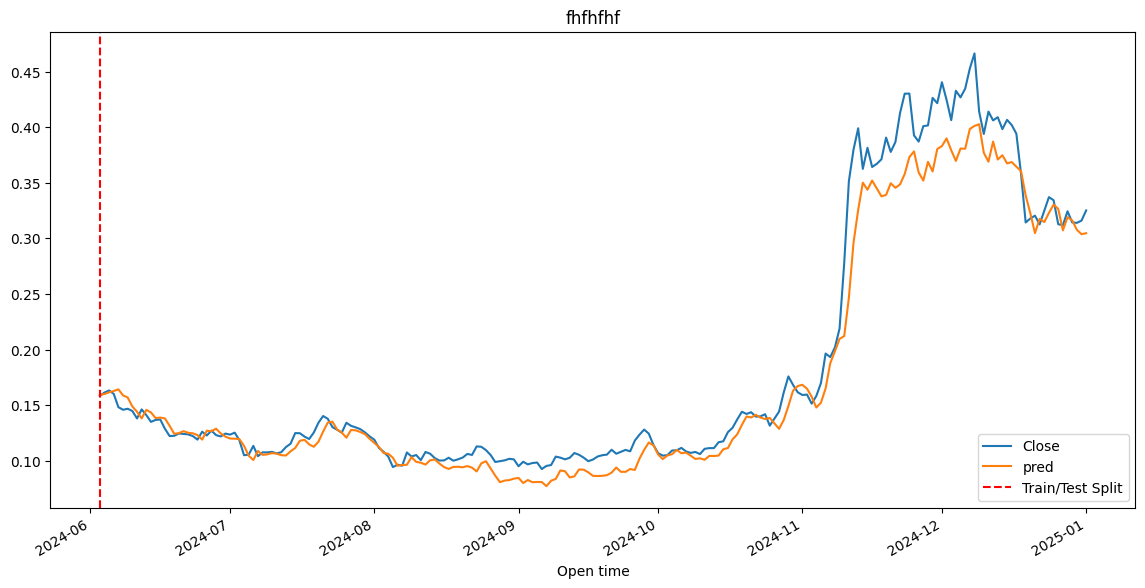

In [9]:
df["pred"] = np.nan
df.loc[df.index[-len(y_pred_inv):], "pred"] = y_pred_inv
df[["Close", "pred"]].iloc[-len(y_pred_inv):].plot(figsize=(14, 7), title="fhfhfhf")

plt.axvline(x=df.index[-len(y_pred_inv)], color='red', linestyle='--', label='Train/Test Split')
plt.legend()

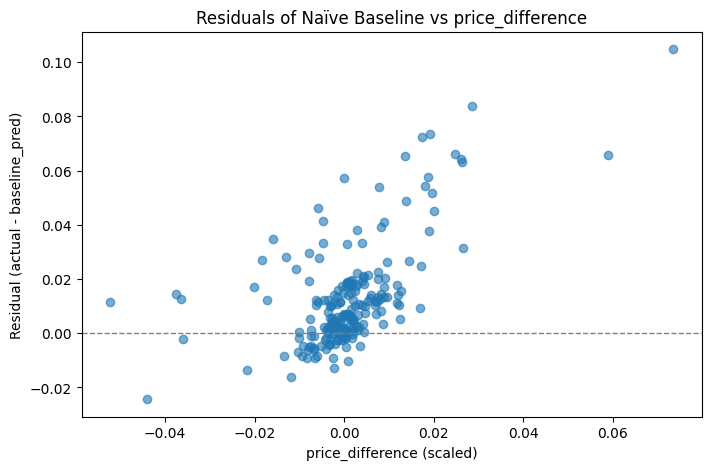

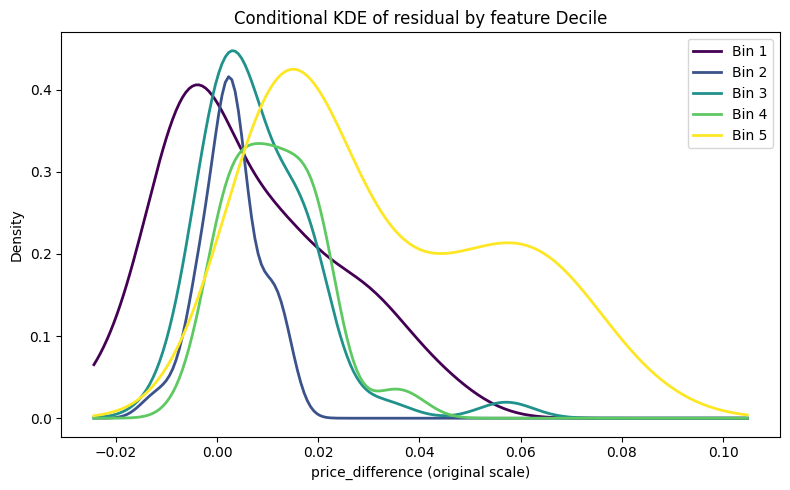

In [10]:
import matplotlib.pyplot as plt
import pandas as pd
import scipy.stats as stats



# 3) Compute residuals relative to baseline
# residuals_baseline = preds - baseline_preds
residuals_baseline = y_val_inv - y_pred_inv

# 4) Extract the same feature (e.g. 'RSI') for X-axis
feature_to_plot = 'price_difference'  # or 'RSI', etc.

X_feat = y_val_inv - pd.Series(y_val_inv).shift(1)


# 5) Plot residuals of the benchmark vs. feature
plt.figure(figsize=(8,5))
plt.scatter(X_feat, residuals_baseline, alpha=0.6)
plt.axhline(0, color='gray', linestyle='--', linewidth=1)
plt.xlabel(f'{feature_to_plot} (scaled)')
plt.ylabel('Residual (actual - baseline_pred)')
plt.title(f'Residuals of Naïve Baseline vs {feature_to_plot}')
plt.show()


# fig, (ax_scatter, ax_hist) = plt.subplots(2, 1, figsize=(8, 10))

# # Scatter: baseline residuals vs feature
# ax_scatter.scatter(X_feat, residuals_baseline, alpha=0.6)
# ax_scatter.axhline(0, color='gray', linestyle='--', linewidth=1)
# ax_scatter.set_xlabel(f'{feature_to_plot} (scaled)')
# ax_scatter.set_ylabel('Residual (actual - baseline_pred)')
# ax_scatter.set_title(f'Residuals of Naïve Baseline vs {feature_to_plot}')

data = pd.DataFrame({'X': residuals_baseline, 'Y': X_feat})
data.dropna(inplace=True)


# bins = np.quantile(data['Y'], np.linspace(0, 1, 11))
# cond_vals = []
# for i in range(len(bins)-1):
#     mask = (data['Y'] >= bins[i]) & (data['Y'] < bins[i+1])
#     x_bin = data.loc[mask, 'X']
#     if len(x_bin) > 1:
#         x_std = (x_bin - x_bin.mean()) / x_bin.std(ddof=0)
#         cond_vals.append(x_std)
# cond_X = pd.concat(cond_vals, ignore_index=True)

# ax_hist.hist(cond_X, bins=30, density=True, alpha=0.7)
# ax_hist.set_xlabel(f'{feature_to_plot} (standardized within Y-bins)')
# ax_hist.set_ylabel('Density')
# ax_hist.set_title('Distribution of Detrended Conditional Feature')

# plt.tight_layout()
# plt.show()

bins = np.quantile(data['Y'], np.linspace(0, 1, 11))
bins = np.quantile(data['Y'], np.linspace(0, 1, 6))

# Prepare a grid for plotting
x_min, x_max = data['X'].min(), data['X'].max()
x_grid = np.linspace(x_min, x_max, 200)

# Choose a colormap and number of bins
cmap = plt.get_cmap("viridis")
n_bins = len(bins) - 1
z_grid = np.linspace(-3, 3, 200)   # covers ±3σ

plt.figure(figsize=(8,5))
for i in range(n_bins):
    mask = (data['Y'] >= bins[i]) & (data['Y'] < bins[i+1])
    x_bin = data.loc[mask, 'X']
    if len(x_bin) > 1:
        # Standardize within bin
        mean_i = x_bin.mean()
        std_i  = x_bin.std(ddof=0)
        x_std = (x_bin - mean_i) / std_i
        
        # Fit KDE on standardized data
        kde = stats.gaussian_kde(x_std)
        
        # Evaluate KDE on grid (standardize grid same as x_bin)
        x_std_grid = (x_grid - mean_i) / std_i
        y_kde = kde(x_std_grid)

        
        z = (x_bin - x_bin.mean()) / x_bin.std(ddof=0)
        # fit KDE
        kde = stats.gaussian_kde(z)
        # evaluate on the z-grid
        y_kde = kde(z_grid)
        
        # Compute color and line width as gradient
        frac = i / (n_bins - 1)
        color = cmap(frac)
        # linewidth = 0.5 + 2.5 * frac
        linewidth = 2

        if len(x_bin) < 30:
            alpha = 0.5
            linewidth = 0.5
        else:
            alpha = 1
        
        plt.plot(
            x_grid, kde(x_std_grid),
            color=color,
            linewidth=linewidth,
            label=f'Bin {i+1}',
            alpha=alpha
        )
        plt.xlabel(f'{feature_to_plot} (original scale)')
        plt.ylabel('Density')

        # plt.plot(
        #     z_grid, kde(z_grid),
        #     color=cmap(frac),
        #     linewidth=0.5 + 2.5*frac,
        #     label=f'Bin {i+1}'
        # )
        # plt.xlabel(f'z-score of {feature_to_plot}')
        # plt.ylabel('Density')

plt.title('Conditional KDE of residual by feature Decile')
plt.legend()
# Optional: only show legend if desired
# plt.legend(bbox_to_anchor=(1.01, 1), loc='upper left')
plt.tight_layout()
plt.show()


In [11]:
# Save the trained model
best_model.save(SAVE_MODEL)

# Save the scaler
joblib.dump(best_scaler, SAVE_SCALER)

# Save the dataframe
best_df_all.to_csv(SAVE_DF)

# Save validation predictions with date index
val_predictions = pd.DataFrame({
    "Date": df.index[-len(best_y_val):],
    "Actual": y_val_inv,
    "Predicted": y_pred_inv
})
val_predictions.set_index("Date", inplace=True)
val_predictions.to_csv(SAVE_PREDICTIONS)